# AI Text Summarizer

### Import Requirements

In [1]:
%pip install rouge_score
%pip install evaluate
%pip install --upgrade -q wandb
%pip install --upgrade datasets
%pip install python-dotenv
%pip install --upgrade transformers
%pip install --upgrade transformers[torch]
%pip install seaborn
%pip install torch 


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: evaluate in c:\python312\lib\site-packages (0.4.3)



Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import AutoTokenizer

import datasets
from datasets import Dataset
from datasets import DatasetDict

from evaluate import load

from tqdm import tqdm

import wandb
import huggingface_hub

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

import warnings
warnings.filterwarnings('ignore')

import evaluate



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ceceh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load environment variables from .env file
load_dotenv()

# Retrieve tokens from environment variables
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
wandb_token = os.getenv("WANDB_API_KEY")





In [4]:
# log in to wandb
wandb.login(key=wandb_token)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ceceh\_netrc
wandb: Currently logged in as: bernicelau to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# log in to Hugging Face Hub
huggingface_hub.login(token=huggingface_token)

In [6]:
# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model checkpoint
model_ckpt = "facebook/bart-base"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [7]:
# Data Analysis
dataset_paths = 'bbc-news-dataset'
articles_path = 'news-articles'
summaries_path = 'summaries'

articles = []
summaries = []
file_arr = []



folders = os.listdir(dataset_paths + '/' + articles_path)

for folder in folders:
    files = os.listdir(dataset_paths + '/' + articles_path + '/' + folder)
    for file in files:
        article_file_path = os.path.join(dataset_paths, articles_path, folder, file)
        summary_file_path = os.path.join(dataset_paths, summaries_path, folder, file)

        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(folder + '/' + file)
        except Exception as e:
            print(f"Error reading file {file} with error {e}")

In [8]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head()

,path,article,summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ..."
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...


In [9]:
# removing nans if any

df.dropna(inplace=True)
df.isnull().sum()

path       0
article    0
summary    0
dtype: int64

In [10]:
# crating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [11]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,path,article,summary,num_words_article,num_words_summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...,416,134
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...,381,158
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...,261,121
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ...",401,197
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...,262,106


In [12]:
# getting statistical info about the word lenghths

df.describe()

,num_words_article,num_words_summary
count,2225.000000,2225.000000
mean,379.314607,165.166742
std,235.032779,108.655971
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.000000,202.000000
max,4377.000000,2073.000000


Upper whisker: 799.0
Q3: 465.0
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


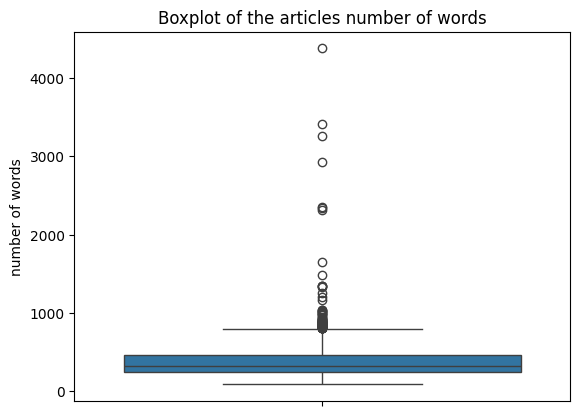

In [13]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,article_lower_whisker,article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 350.0
Q3: 202.0
Q2: 142.0
Q1: 103.0
Lower whisker: 38.0


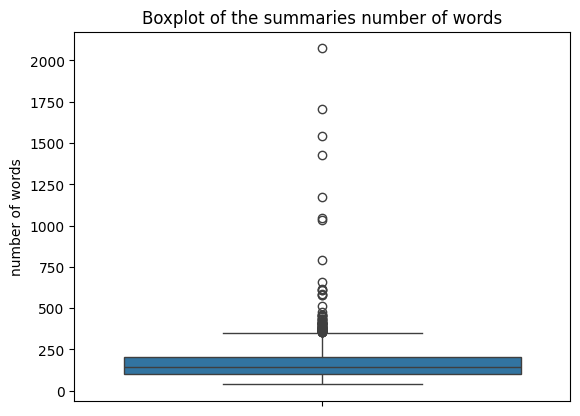

In [14]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,summary_lower_whisker,summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [15]:
# removing the samples of very long sequences

new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,summary,num_words_article,num_words_summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...,416,134
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...,381,158
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...,261,121
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ...",401,197
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...,262,106
...,...,...,...,...,...
2215,tech/392.txt,Broadband fuels online expression..Fast web ac...,More than five million households in the UK ha...,331,91
2216,tech/393.txt,Savvy searchers fail to spot ads..Internet sea...,Almost 50% of those questioned said they would...,496,199
2220,tech/397.txt,BT program to beat dialler scams..BT is introd...,BT is introducing two initiatives to help beat...,416,186
2221,tech/398.txt,Spam e-mails tempt net shoppers..Computer user...,A third of them read unsolicited junk e-mail a...,352,130


In [16]:
# preparing the data by training 0.03% of the dataset

# deleting some columns and shuffling the rows

new_df.drop(columns=["num_words_article","num_words_summary","path"])
new_df = new_df.sample(frac = 0.03)
new_df.reset_index(drop=True, inplace=False)

,path,article,summary,num_words_article,num_words_summary
0,tech/016.txt,Global blogger action day called..The global w...,"""If you have a blog, the least you could do is...",682,345
1,politics/074.txt,BNP leader Nick Griffin arrested..The leader o...,Mr Griffin is the twelfth man to be arrested f...,198,85
2,tech/175.txt,Broadband in the UK growing fast..High-speed n...,"The 600,000 connections take the total number ...",416,177
3,sport/473.txt,Faultless Federer has no equal..Roger Federer ...,"""If I can promote tennis and the sport then th...",417,183
4,sport/363.txt,Calder fears for Scottish rugby..Former Scotla...,"said Calder.And Calder said: ""This is terrible...",289,118
...,...,...,...,...,...
59,politics/130.txt,Blair told to double overseas aid..Tony Blair ...,"The report said: ""For rich countries, providin...",430,183
60,sport/067.txt,Lewis-Francis eyeing world gold..Mark Lewis-Fr...,Mark Lewis-Francis says his Olympic success ha...,178,76
61,business/062.txt,Wembley firm won't make a profit..Shares in Mu...,"To recoup any profit from Wembley, where the f...",314,119
62,sport/266.txt,Benitez 'to launch Morientes bid'..Liverpool m...,The fee could put Liverpool off a prospective ...,149,87


In [17]:
# splitting the data into train and test 

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [18]:
# convert the DataFrame into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 51
    })
    test: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 13
    })
})

In [19]:
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [20]:
# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# define max input lengths
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

In [21]:
# ROUGE metric for automatic summarization and machine translation software in Natural Language Processing

rouge_score = evaluate.load("rouge")

In [22]:
# example on using rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

In [23]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    return {k: round(v, 4) for k, v in result.items()}

In [24]:
# generate summaries
summarizer = pipeline("summarization", model=model_ckpt)

def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Summary: {summary}'")
    print(f"\n'>>> Generated Summary: {g_summary}'")
    print(f"\n'>>> ROUGE Score: {scores}'")
    
    
print_summary(5)

Device set to use cpu


'>>> Article: 'My memories of Marley...'..To mark the 60th anniversary of the birth of reggae star Bob Marley, Rob Partridge - Marley's former head of press at Island Records - remembers the man behind the legend...Partridge worked with Marley from 1977 until the Jamaican musician's death in 1981...: "I joined Island Records in 1977 and the first week I was there I worked on his show at the Rainbow Theatre. It was one of the last dates he did in London."..: The album Exodus came out in 1977 and that provided five hits and confirmed his global superstar status. "By 1979 he was the biggest touring attraction in the world. I remember going to see dates in Milan and Turin and they were enormous concerts."..: Bob was one of the most mesmeric people I've ever had the privilege to work with. "He must have had an iron will to succeed. Bob was a very driven individual. You realised from the start there was a manifest destiny within him that he believed in. He didn't suffer fools gladly. At the 

In [25]:
# fine tuning BART model

# creating data_collator 
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [26]:
# removing the columns with strings because the collator won’t know how to pad these elements

tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [27]:
batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
    run_name="text_summmarizer",
    report_to="wandb", # ensures WandB logging is enabled
    )

In [28]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

In [29]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


CommError: failed to upsert bucket: returned error 403 Forbidden: {"errors":[{"message":"permission denied","path":["upsertBucket"],"extensions":{"code":"PERMISSION_ERROR"}}],"data":{"upsertBucket":null}}